In [1]:
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd

ff1.Cache.enable_cache('cache')

In [32]:
#loading the session data
year = 2022
circuit = 'Silverstone'
session = 'FP2'
race = ff1.get_session(year, circuit, session)
laps = race.load_laps(with_telemetry=True)

core        WARNING 	Ergast API lookup failed. The session is very recent and not yet available or does not exist.
core           INFO 	Loading laps for British Grand Prix - Practice 2 [v2.2.0-alpha0]
api            INFO 	No cached data found for timing_data. Loading data...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_app_data. Loading data...
api            INFO 	Fetching timing app data...
api            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
api            INFO 	No cached data found for driver_info. Loading data...
api            INFO 	Fetching driver list...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for session_status_data. Loading data...
api            INFO 	Fetching session status data...
api            INFO 	Data has been written to

In [33]:
#creating lapTimes: contains only information about the lap time, the driver, the tyre
lapTimes = laps[['DriverNumber','LapStartTime','Time','PitOutTime','PitInTime','Compound', 'FreshTyre','LapTime']]
lapstartlist = []
laptimelist = []

#laptimesgood: a list of all the laptimes in "x:xx.x" format
ltt = laps["LapTime"].tolist()
laptimesgood = []
for x in ltt:
    y = str(x)
    y = y[11:17]
    laptimesgood.append(y)


lst = lapTimes["LapStartTime"].tolist()
t = lapTimes["Time"].tolist()
pit = lapTimes["PitInTime"].tolist()
pot = lapTimes["PitOutTime"].tolist()

#lapstartlist: a list of all the start times of the laps
#laptimelist: a list of all the lap times
for x in range(len(lst)):
    if str(pot[x]) == "NaT":
        lapstart = lst[x].total_seconds()/60
    else:
        lapstart = pot[x].total_seconds()/60
    if str(pit[x]) == "NaT":
        lapend = t[x].total_seconds()/60
    else:
        lapend = pit[x].total_seconds()/60

    laptime = lapend-lapstart
    lapstartlist.append(lapstart)
    laptimelist.append(laptime)


In [34]:
#firstlapstart: time at which the session started
firstlapstart = 99999
for x in range(len(lapstartlist)):
    if str(lapstartlist[x])!='nan':
        if firstlapstart>lapstartlist[x]:
            firstlapstart=lapstartlist[x]
for x in range(len(lapstartlist)):
    lapstartlist[x]=lapstartlist[x]-firstlapstart

In [35]:
#gooddf: lapTimes but with updated time data
gooddf = lapTimes

del gooddf["LapStartTime"]
del gooddf["Time"]
del gooddf["PitInTime"]
del gooddf["PitOutTime"]
gooddf["StartTimes"] = lapstartlist
gooddf["LapTimes"] = laptimelist
gooddf["LTPretty"] = laptimesgood


<ipython-input-35-599e82802eca>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gooddf["StartTimes"] = lapstartlist
<ipython-input-35-599e82802eca>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gooddf["LapTimes"] = laptimelist
<ipython-input-35-599e82802eca>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [36]:
#drivers_to_Visualize: list of drivers that will be on the graph
drivers_to_visualize = ['6','23','47','20','18','5','22','10','24','77','14','31','3','4','44','63','55','16','11','1']

In [37]:
#cleaning the compound and freshness data
comp = gooddf["Compound"].tolist()
ft = gooddf["FreshTyre"].tolist()
for x in range(len(ft)):
    if str(comp[x])=='nan':
        comp[x]="UNKNOWN"
    if ft[x]:
        ft[x]="True"
    else:
        ft[x]="False"


In [38]:
compft = []
isFastest = []
for i in range(len(ft)):
    isFastest.append("false")
for number in drivers_to_visualize:
    driver_laps = gooddf[gooddf["DriverNumber"]==number]
    try:
        y = driver_laps["LapTime"].idxmin()
        isFastest[y]="true"
    except:
        print("no fastest lap for driver number "+number)
for x in range(len(ft)):
    if isFastest[x]!='true':
        y = comp[x]+'_'+ft[x]
    else:
        y = "personalBest"
    compft.append(y)

gooddf["Compound_Freshness"] = compft

<ipython-input-38-f8d4e5e6741e>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gooddf["Compound_Freshness"] = compft


In [39]:
compound_colors = {
    'SOFT_True': '#FF3333',
    'MEDIUM_True': '#FFF200',
    'HARD_True': '#EBEBEB',
    'INTERMEDIATE_True': '#39B54A',
    'WET_True': '#00AEEF',
    'UNKNOWN_True': '#555555',
    'SOFT_False': '#762525',
    'MEDIUM_False': '#7c7600',
    'HARD_False': '#999999',
    'INTERMEDIATE_False': '#2b8737',
    'WET_False': '#0078a5',
    'UNKNOWN_False': '#555555',
    'TEST_UNKNOWN_False': '#555555',
    'TEST_UNKNOWN_True': '#555555',
    'personalBest': '#b138dd'
}

In [40]:
prettylaps = []
for driver in drivers_to_visualize:
    laps = gooddf.loc[gooddf['DriverNumber'] == driver]
    x = laps['LTPretty'].tolist()
    for lap in x:
        prettylaps.append(lap)

In [41]:
laptimepretty = []
for x in laptimelist:
    z,y = divmod(x,1)
    y = (60*y)/100
    y = round(y,5)
    ltp = y+z
    laptimepretty.append(ltp)


category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbe

category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbe

category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbe

category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbe

category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbe

category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbe

category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbe

category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbe

category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbe

category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbe

category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbe

category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbe

category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


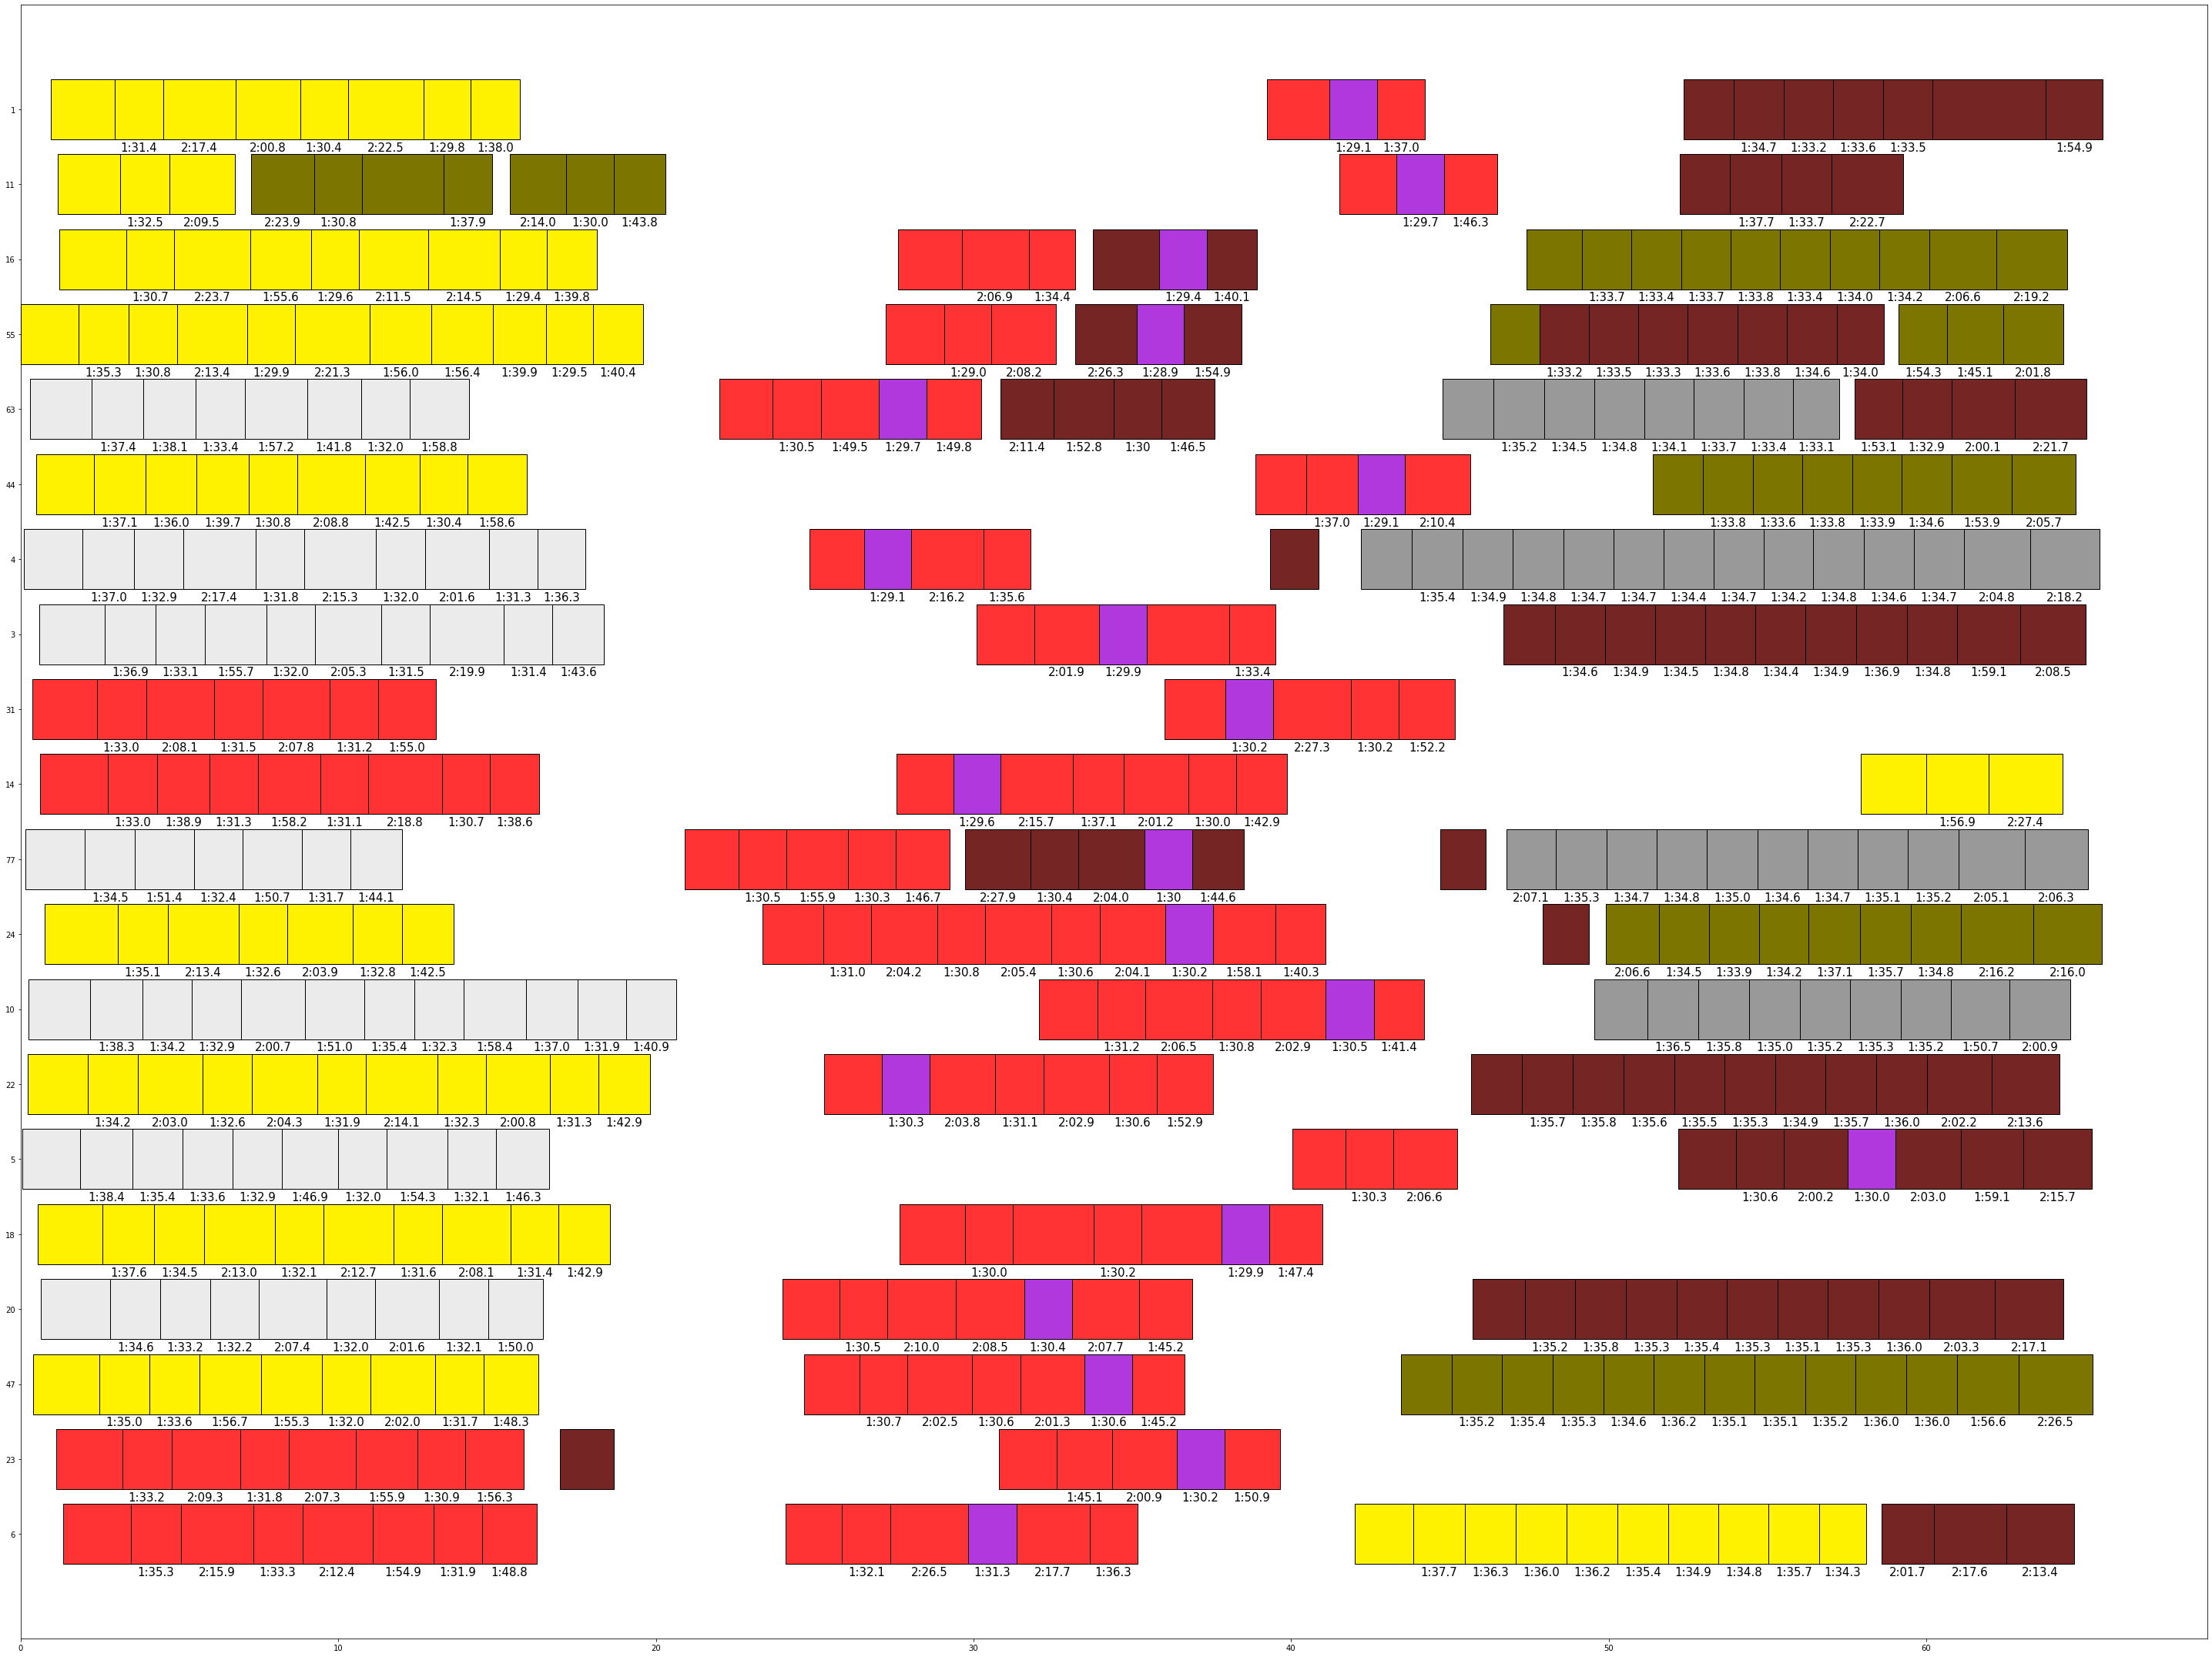

In [42]:
#drivers_to_visualize = ['1','11','4','3','6','23','27','18','10','22','14','31','24','77','47','20','63','44','55','16']
plt.rcParams["figure.figsize"] = [40,30]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()
for driver in drivers_to_visualize:
    laps = gooddf.loc[gooddf['DriverNumber'] == driver]
    previous_stint_end = gooddf['StartTimes']
    for _, lap in laps.iterrows():
            
        plt.barh([driver],lap['LapTimes'],left = lap['StartTimes'], 
                 color = compound_colors[lap['Compound_Freshness']],
                 edgecolor = "black")

for bar, time in zip(ax.patches,prettylaps):
    ax.text((2*bar.get_x()+bar.get_width())/2 ,bar.get_y()-0.185, time,ha="center", va="bottom",fontsize=15)

fig.patch.set_facecolor('white')